In [73]:
import tensorflow as tf
import tensorflow_addons as tfa
from svhn_dataset import SVHN
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [83]:
dataset = SVHN().train.map(SVHN.parse)
for sample in dataset.take(10):
    pass
print(sample['image'].shape)
print(sample.keys())
sizes = np.array([x['image'].shape[0] for x in dataset.as_numpy_iterator()])
print(f'training samples: {len(sizes)}')
print(f'max size: {np.max(sizes)}')
print(f'min size: {np.min(sizes)}')
print(f'mean size: {np.mean(sizes)}')
print(f'number of samples bigger then 128: {np.sum(sizes > 128)}')
print(f'number of samples bigger then 256: {np.sum(sizes > 256)}')

(40, 40, 3)
dict_keys(['bboxes', 'classes', 'image'])
training samples: 10000
max size: 293
min size: 18
mean size: 76.3944
number of samples bigger then 128: 1011
number of samples bigger then 256: 15


max size: 293
size: (18, 18, 3)


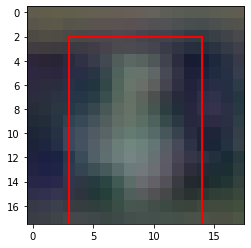

In [91]:
input_size = 128


for sample in dataset.take(6406):
    pass

@tf.function
def scale(x):
    return dict(image = x['image'],
                classes = x['classes'],
                bboxes = x['bboxes'])



def draw_image_and_bb(image, bbs):
    print(f'size: {image.shape}')
    plt.imshow(image)
    ax = plt.gca()
    for bb in bbs:
        ymin, xmin, ymax, xmax = bb.numpy()
        y, x = (ymin + ymax) / 2, (xmin + xmax) / 2
        h, w = (ymax - ymin), (xmax - xmin)
        rect = patches.Rectangle((xmin, ymin),w,h,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

print(f'max size: {max_size}')
draw_image_and_bb(sample['image'].numpy(), sample['bboxes'])

# Dataset properties
max size: 293
mean size: 76.4
number of images bigger than 128: 1011
train size: 10000

In [182]:
def generate_anchors(pyramid_levels, image_size, first_feature_scale=4, anchor_scale=4.0, aspect_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)], num_scales=3): 
    boxes_all = []
    for s in range(pyramid_levels):
        boxes_level = []
        for octave in range(num_scales):
            for aspect_h, aspect_w in aspect_ratios:
                scale = 2 ** (octave / num_scales)
                stride = first_feature_scale * 2 ** s
                base_anchor_size = anchor_scale * stride * scale
                anchor_size_x = base_anchor_size * aspect_w / 2.0
                anchor_size_y = base_anchor_size * aspect_h / 2.0

                x = np.arange(stride / 2, image_size, stride)
                y = np.arange(stride / 2, image_size, stride)
                xv, yv = np.meshgrid(x, y)
                xv = xv.reshape(-1)
                yv = yv.reshape(-1)

                boxes = np.vstack((yv - anchor_size_y, xv - anchor_size_x,
                    yv + anchor_size_y, xv + anchor_size_x))
                boxes = np.swapaxes(boxes, 0, 1)
                boxes_level.append(np.expand_dims(boxes, axis=1))
        boxes_level = np.concatenate(boxes_level, axis=1)
        boxes_all.append(boxes_level.reshape(-1, 4))
    return np.vstack(boxes_all) 

anchors = generate_anchors(4, 128, anchor_scale=3.0, first_feature_scale =4)

In [178]:
from importlib import reload
import efficientdet
reload(efficientdet)
net = efficientdet.EfficientDet(5, 9, input_size= 128)

(None, 4, 4, 1280),(None, 8, 8, 112),(None, 16, 16, 40),(None, 32, 32, 24)
(None, 32, 32, 24)


In [179]:
input_tensor = tf.random.uniform((2, 128, 128, 3), dtype=tf.float32)
output = net(input_tensor)
print(output[0].shape)
print(output[1].shape)

(2, 12240, 5)
(2, 12240, 4)
